# 라이브러리 불러오기

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

import gc

import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# 데이터 불러오기

- 데이터 정보

In [23]:
info = pd.read_csv("제주도 교통량 예측/data_info.csv")
info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


- 메모리를 줄이기 위해 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업으로 사용 가능

In [24]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'제주도 교통량 예측/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')
    
csv_to_parquet('제주도 교통량 예측/train.csv', 'train')
csv_to_parquet('제주도 교통량 예측/test.csv', 'test')

train Done.
test Done.


In [25]:
train = pd.read_parquet('제주도 교통량 예측/train.parquet')
test = pd.read_parquet('제주도 교통량 예측/test.parquet')

In [26]:
train.sample(3)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
1582031,TRAIN_1582031,20220701,금,6,2,103,일반국도12호선,0,0,60.0,...,3,외도교,33.494067,126.435871,없음,외도교,33.494205,126.436671,없음,54.0
3366023,TRAIN_3366023,20220131,월,8,2,103,일반국도12호선,0,0,60.0,...,0,연수동삼거리,33.519338,126.874347,없음,세화입구,33.518311,126.861000,없음,41.0
2417218,TRAIN_2417218,20220115,토,21,3,106,지방도1132호선,0,0,70.0,...,3,제주시 삼양2동 2186-1,33.521264,126.581398,있음,삼양동사무소,33.521098,126.585400,없음,28.0


In [27]:
test.sample(3)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
63932,TEST_063932,20220804,목,1,1,103,일반국도16호선,0,0,80.0,...,0.0,3,월산마을,33.472819,126.463030,없음,월산정수장입구,33.478257,126.468081,있음
4219,TEST_004219,20220828,일,17,3,103,일반국도12호선,0,0,70.0,...,0.0,0,인제사거리,33.507384,126.540331,있음,영락교회,33.509729,126.543144,있음
120,TEST_000120,20220806,토,8,2,107,새서귀로,0,0,60.0,...,0.0,0,삼주연립101동,33.251045,126.510574,없음,시청입구1,33.249029,126.509864,없음


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   lane_count             291241 non-null  int64  
 5   road_rating            291241 non-null  int64  
 6   road_name              291241 non-null  object 
 7   multi_linked           291241 non-null  int64  
 8   connect_code           291241 non-null  int64  
 9   maximum_speed_limit    291241 non-null  float64
 10  vehicle_restricted     291241 non-null  float64
 11  weight_restricted      291241 non-null  float64
 12  height_restricted      291241 non-null  float64
 13  road_type              291241 non-null  int64  
 14  start_node_name        291241 non-nu

# 데이터 시각화

- train과 test의 비교 분석
- 참고 : https://dacon.io/competitions/official/235985/codeshare/6856?page=1&dtype=recent

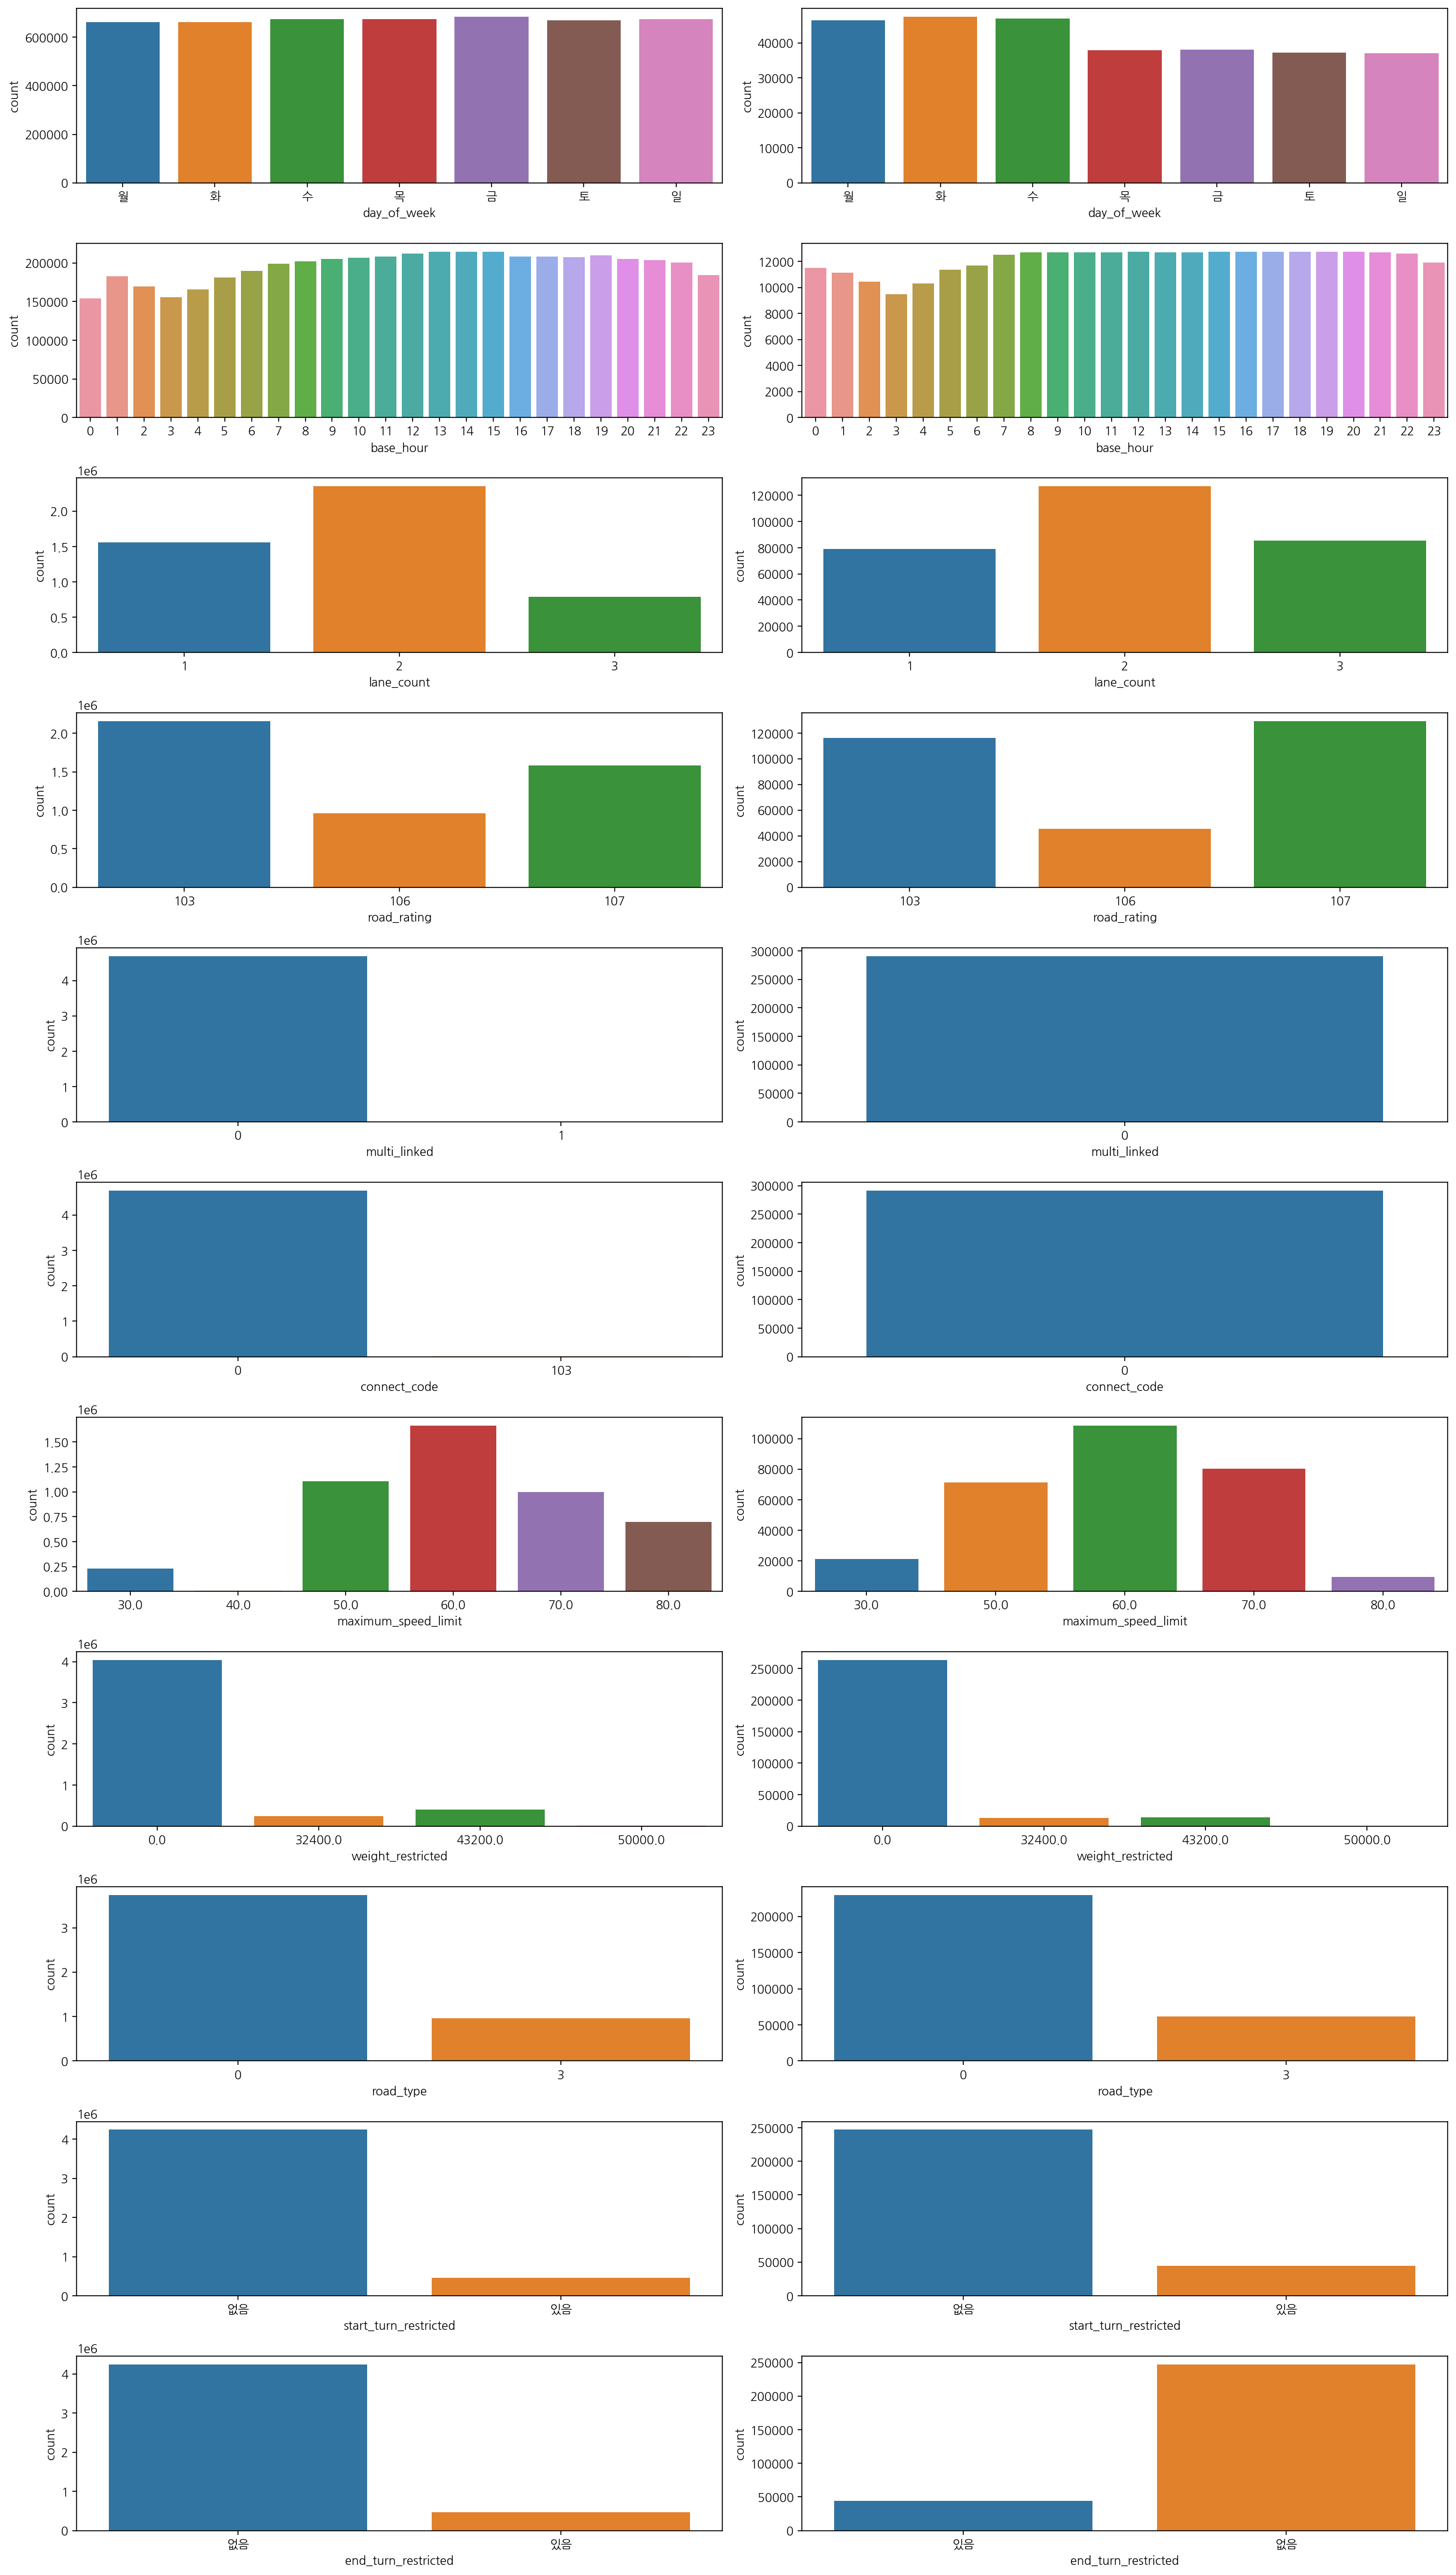

In [30]:
date_order = ['월','화','수','목','금','토','일']

fig, axes = plt.subplots(11, 2, figsize=(17,30))

sns.countplot(x='day_of_week', data=train, ax=axes[0][0],order=date_order)
sns.countplot(x='day_of_week', data=test, ax=axes[0][1],order=date_order)
sns.countplot(x='base_hour', data=train, ax=axes[1][0])
sns.countplot(x='base_hour', data=test, ax=axes[1][1])
sns.countplot(x='lane_count', data=train, ax=axes[2][0])
sns.countplot(x='lane_count', data=test, ax=axes[2][1])
sns.countplot(x='road_rating', data=train, ax=axes[3][0])
sns.countplot(x='road_rating', data=test, ax=axes[3][1])
sns.countplot(x='multi_linked', data=train, ax=axes[4][0])
sns.countplot(x='multi_linked', data=test, ax=axes[4][1])
sns.countplot(x='connect_code', data=train, ax=axes[5][0])
sns.countplot(x='connect_code', data=test, ax=axes[5][1])
sns.countplot(x='maximum_speed_limit', data=train, ax=axes[6][0])
sns.countplot(x='maximum_speed_limit', data=test, ax=axes[6][1])
sns.countplot(x='weight_restricted', data=train, ax=axes[7][0])
sns.countplot(x='weight_restricted', data=test, ax=axes[7][1])
sns.countplot(x='road_type', data=train, ax=axes[8][0])
sns.countplot(x='road_type', data=test, ax=axes[8][1])
sns.countplot(x='start_turn_restricted', data=train, ax=axes[9][0])
sns.countplot(x='start_turn_restricted', data=test, ax=axes[9][1])
sns.countplot(x='end_turn_restricted', data=train, ax=axes[10][0])
sns.countplot(x='end_turn_restricted', data=test, ax=axes[10][1])

plt.tight_layout()
plt.show()

- 상관계수 시각화

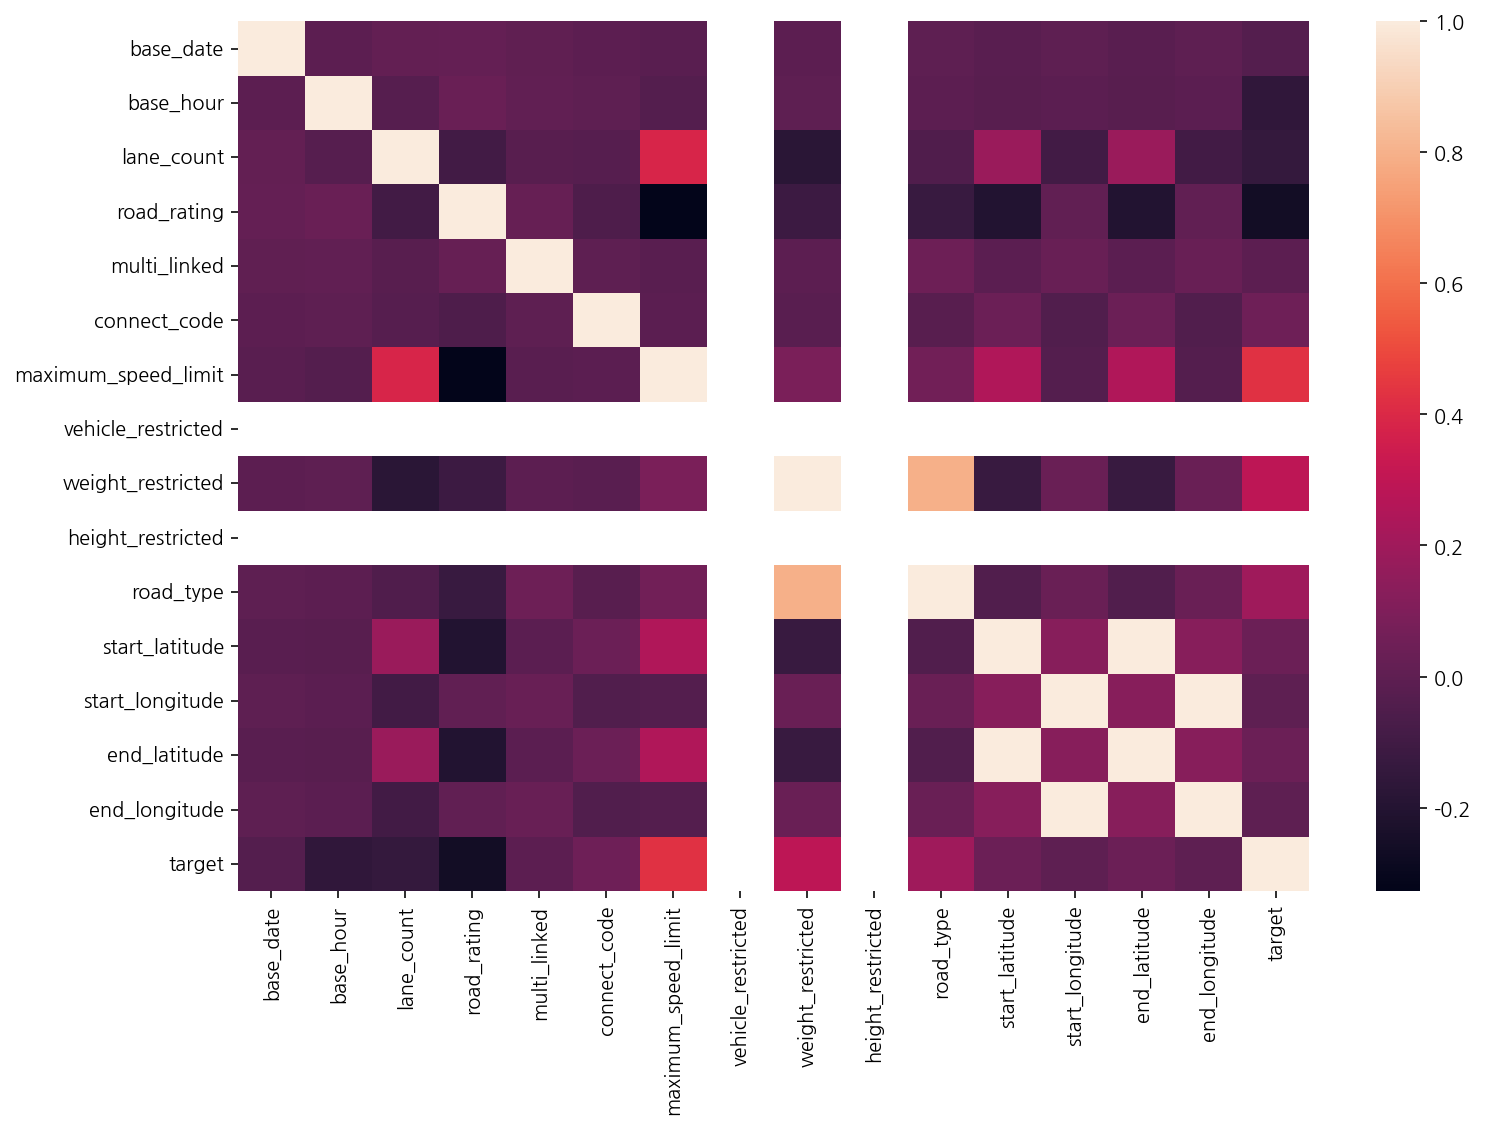

In [31]:
plt.figure(figsize=(12,8))
_=sns.heatmap(train.corr())

# 데이터 전처리

- id feature에서의 id만 남긴다.

In [32]:
# id feature에 대한 전처리
train['id'] = train['id'].str[6:]
test['id'] = test['id'].str[5:]

train['id'] = train['id'].astype(int)
test['id'] = test['id'].astype(int)

display(train.sample(3))
display(test.sample(3))

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
381392,381392,20211229,수,23,3,106,지방도1132호선,0,0,70.0,...,0,시청입구2,33.249949,126.505664,없음,월드컵경기장,33.249583,126.507874,없음,42.0
3440521,3440521,20220220,일,15,3,103,일반국도12호선,0,0,70.0,...,0,동홍사거리,33.254628,126.567678,없음,중앙교,33.254233,126.565958,없음,39.0
3102862,3102862,20211227,월,19,3,106,동부관광도로,0,0,50.0,...,0,국립제주박물관,33.511579,126.547564,있음,거로사거리,33.507349,126.556173,있음,46.0


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
202321,202321,20220823,화,4,2,107,경찰로,0,0,60.0,...,0.0,0,의료보험조합,33.255659,126.507333,없음,국민의료보험관리공단,33.254782,126.507014,없음
48413,48413,20220815,월,8,3,107,시청로,0,0,60.0,...,0.0,0,한국통신,33.255094,126.509577,없음,우체국,33.255286,126.508813,없음
127040,127040,20220813,토,4,2,107,새서귀로,0,0,60.0,...,0.0,0,한솔고기국수,33.251947,126.510894,없음,큰집솥뚜껑,33.252798,126.511195,없음


- road_name feature에서의 '-'은 알 수 없음으로 변경

In [33]:
# train
name = []
for x in train['road_name']:
    if x == '-':
        name.append('알 수 없음')
    else:
        name.append(x)

train['road_name'] = name
display(train[['road_name']].sample(3))

# test
name2 = []
for x in test['road_name']:
    if x == '-':
        name2.append('알 수 없음')
    else:
        name2.append(x)

test['road_name'] = name2
display(test[['road_name']].sample(3))

,road_name
2656293,일반국도12호선
1361549,알 수 없음
4463742,일반국도12호선


,road_name
204368,중문로
34532,권학로
151217,시청로


- 문자열에 대한 Label Encoding

In [34]:
le = LabelEncoder()

# train
train['day_of_week'] = le.fit_transform(train['day_of_week']) 
train['road_name'] = le.fit_transform(train['road_name'])
train['start_node_name'] = le.fit_transform(train['start_node_name'])
train['start_turn_restricted'] = le.fit_transform(train['start_turn_restricted'])
train['end_node_name'] = le.fit_transform(train['end_node_name'])
train['end_turn_restricted'] = le.fit_transform(train['end_turn_restricted'])

# test
test['day_of_week'] = le.fit_transform(test['day_of_week']) 
test['road_name'] = le.fit_transform(test['road_name'])
test['start_node_name'] = le.fit_transform(test['start_node_name'])
test['start_turn_restricted'] = le.fit_transform(test['start_turn_restricted'])
test['end_node_name'] = le.fit_transform(test['end_node_name'])
test['end_turn_restricted'] = le.fit_transform(test['end_turn_restricted'])

display(train.sample(3))
display(test.sample(3))

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
590324,590324,20220529,4,11,1,107,25,0,0,50.0,...,0,215,33.460276,126.930941,0,8,33.450215,126.920771,0,41.0
391666,391666,20211106,5,7,2,107,25,0,0,50.0,...,0,34,33.330822,126.354179,0,44,33.330673,126.354987,0,61.0
3183624,3183624,20210923,1,13,1,103,34,0,0,60.0,...,3,239,33.337158,126.610343,0,240,33.336756,126.610141,0,48.0


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
189726,189726,20220801,3,0,2,107,28,0,0,60.0,...,0.0,3,158,33.482332,126.442266,0,161,33.482392,126.441622,0
57223,57223,20220812,0,9,3,106,40,0,0,70.0,...,0.0,0,121,33.249029,126.509864,0,168,33.249583,126.507874,0
199746,199746,20220823,6,7,1,103,30,0,0,60.0,...,0.0,0,156,33.492539,126.426231,0,160,33.492699,126.428241,0


- 메모리를 줄이기 위한 downcasting

In [35]:
# train
for col in train.columns:
    dtype_name = train[col].dtypes.name
    if dtype_name.startswith("int"):
        if train[col].min() >= 0:
            train[col] = pd.to_numeric(train[col], downcast="unsigned")
        else:
            train[col] = pd.to_numeric(train[col], downcast="integer")
    elif dtype_name.startswith("float"):
        train[col] = pd.to_numeric(train[col], downcast="float")
    elif dtype_name == "bool":
        train[col] = train[col].astype("int8")
    elif dtype_name == "object":
        train[col] = train[col].astype("category")
        
# test
for col in test.columns:
    dtype_name = test[col].dtypes.name
    if dtype_name.startswith("int"):
        if test[col].min() >= 0:
            test[col] = pd.to_numeric(test[col], downcast="unsigned")
        else:
            test[col] = pd.to_numeric(test[col], downcast="integer")
    elif dtype_name.startswith("float"):
        test[col] = pd.to_numeric(test[col], downcast="float")
    elif dtype_name == "bool":
        test[col] = test[col].astype("int8")
    elif dtype_name == "object":
        test[col] = test[col].astype("category")
        
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     uint32 
 1   base_date              uint32 
 2   day_of_week            uint8  
 3   base_hour              uint8  
 4   lane_count             uint8  
 5   road_rating            uint8  
 6   road_name              uint8  
 7   multi_linked           uint8  
 8   connect_code           uint8  
 9   maximum_speed_limit    float32
 10  vehicle_restricted     float32
 11  weight_restricted      float32
 12  height_restricted      float32
 13  road_type              uint8  
 14  start_node_name        uint16 
 15  start_latitude         float32
 16  start_longitude        float32
 17  start_turn_restricted  uint8  
 18  end_node_name          uint16 
 19  end_latitude           float32
 20  end_longitude          float32
 21  end_turn_restricted    uint8  
 22  target            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  uint32 
 1   base_date              291241 non-null  uint32 
 2   day_of_week            291241 non-null  uint8  
 3   base_hour              291241 non-null  uint8  
 4   lane_count             291241 non-null  uint8  
 5   road_rating            291241 non-null  uint8  
 6   road_name              291241 non-null  uint8  
 7   multi_linked           291241 non-null  uint8  
 8   connect_code           291241 non-null  uint8  
 9   maximum_speed_limit    291241 non-null  float32
 10  vehicle_restricted     291241 non-null  float32
 11  weight_restricted      291241 non-null  float32
 12  height_restricted      291241 non-null  float32
 13  road_type              291241 non-null  uint8  
 14  start_node_name        291241 non-nu

None

- 필요없는 칼람 제거하기

In [36]:
train = train.drop(['id', 'base_date','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)
test = test.drop(['id', 'base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

display(train.sample(3))
display(test.sample(3))

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted,target
3676494,3,2,2,103,0,0,80.0,0.0,0.0,0,33.404850,126.269432,0,33.398663,126.263634,0,65.0
1030432,2,12,2,103,0,0,80.0,0.0,0.0,0,33.441021,126.429512,0,33.443359,126.431587,0,54.0
116840,1,8,1,106,0,0,60.0,0.0,0.0,0,33.435940,126.736252,0,33.438866,126.744385,0,49.0


,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
68747,2,6,2,103,0,0,70.0,0.0,0.0,0,33.263592,126.623207,1,33.263622,126.623940,0
265829,5,18,2,103,0,0,60.0,0.0,0.0,0,33.493549,126.479240,0,33.493599,126.477165,0
229243,0,11,2,107,0,0,50.0,0.0,0.0,0,33.485886,126.489975,0,33.485973,126.486412,0


# 모델링 학습 및 평가

- trian, test 데이터 나누기

In [37]:
label_name = 'target'

X_train = train.iloc[:, :-1]
y_train = train[label_name]
X_test = test

display(X_train)
display(y_train)
display(X_test)

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,1,106,0,0,60.0,32400.0,0.0,3,33.427746,126.662613,0,33.427750,126.662338,0
1,1,21,2,103,0,0,60.0,0.0,0.0,0,33.500729,126.529106,1,33.504810,126.526237,0
2,4,7,2,103,0,0,80.0,0.0,0.0,0,33.279144,126.368599,0,33.280071,126.362144,0
3,0,13,2,107,0,0,50.0,0.0,0.0,0,33.246082,126.567207,0,33.245564,126.566231,0
4,6,8,2,103,0,0,80.0,0.0,0.0,0,33.462215,126.326553,0,33.462677,126.330154,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701212,1,16,1,107,0,0,50.0,0.0,0.0,0,33.422146,126.278122,0,33.420956,126.273750,0
4701213,1,2,2,107,0,0,80.0,43200.0,0.0,3,33.472504,126.424370,0,33.472527,126.424889,0
4701214,3,22,2,103,0,0,60.0,0.0,0.0,0,33.447182,126.912582,0,33.444122,126.912949,0
4701215,2,2,2,103,0,0,80.0,0.0,0.0,0,33.443596,126.431816,0,33.444996,126.433334,0


0          52.0
1          30.0
2          61.0
3          20.0
4          38.0
           ... 
4701212    20.0
4701213    65.0
4701214    30.0
4701215    73.0
4701216    35.0
Name: target, Length: 4701217, dtype: float32

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,1,17,3,107,0,0,70.0,0.0,0.0,0,33.499428,126.541298,0,33.500774,126.543839,1
1,6,12,2,103,0,0,70.0,0.0,0.0,3,33.258507,126.427002,0,33.258118,126.415840,0
2,0,2,1,103,0,0,60.0,0.0,0.0,0,33.258961,126.476509,0,33.259205,126.474686,0
3,1,23,3,103,0,0,70.0,0.0,0.0,0,33.473495,126.545647,0,33.471062,126.545464,0
4,2,17,3,106,0,0,70.0,0.0,0.0,0,33.501476,126.569221,0,33.496864,126.581230,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291236,5,5,1,103,0,0,80.0,0.0,0.0,0,33.472820,126.463028,0,33.470482,126.460846,0
291237,0,20,2,103,0,0,60.0,0.0,0.0,0,33.305359,126.598915,0,33.300797,126.600334,0
291238,0,11,1,107,0,0,30.0,0.0,0.0,0,33.493622,126.496773,1,33.497501,126.496948,1
291239,0,7,2,107,0,0,60.0,0.0,0.0,0,33.254784,126.507011,0,33.255661,126.507332,0


- 사용할 모델

In [40]:
model = lgb.LGBMClassifier()
model

LGBMClassifier()

- GridsearchCV를 이용한 최적의 하이퍼 파라미터 찾기 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_lgb = {'num_leaves':[20,40,60,80,100], 
             'min_child_samples':[5,8,10],
             'max_depth':[5,10,20],
             'learning_rate':[0.05,0.01,0.1]
            }

gscv = GridSearchCV(estimator = model, param_grid=param_lgb, scoring='accuracy')
gscv.fit(X_train, y_train)
print('Ran 파라미터 : ', gscv.best_params_)
print('Ran 예측 정확도 : {:.4f}'.format(gscv.best_score_))

- 최적의 파라미터로 모델링

In [37]:
model_best = lgb.LGBMClassifier()
model_best

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

- CV results

In [ ]:
pd.DataFrame(cross_validate(model_best, X_train, y_train, cv=5))

- 최적의 파라미터로 학습 및 예측

In [ ]:
mdel_best.fit(X_train, y_train)

In [ ]:
pred = model_best.predict(X_test)
pred[:5]

# 제출을 위한 파일 생성

In [32]:
submission = pd.read_csv("제주도 교통량 예측/sample_submission.csv", index_col='id')
submission

,target
id,
TEST_000000,0
TEST_000001,0
TEST_000002,0
TEST_000003,0
TEST_000004,0
...,...
TEST_291236,0
TEST_291237,0
TEST_291238,0


In [33]:
submission['target'] = pred
submission

,target
id,
TEST_000000,25.120286
TEST_000001,45.135732
TEST_000002,58.431185
TEST_000003,37.628058
TEST_000004,38.267574
...,...
TEST_291236,58.772498
TEST_291237,53.458449
TEST_291238,17.210346


In [35]:
submission.to_csv("제주도 교통량 예측/lgbm.csv")

In [36]:
pd.read_csv("제주도 교통량 예측/lgbm.csv")

,id,target
0,TEST_000000,25.120286
1,TEST_000001,45.135732
2,TEST_000002,58.431185
3,TEST_000003,37.628058
4,TEST_000004,38.267574
...,...,...
291236,TEST_291236,58.772498
291237,TEST_291237,53.458449
291238,TEST_291238,17.210346
291239,TEST_291239,23.535838
